# Test loading model from keras file

In this notebook I am testing loading weights for previously trained model to make sure that it gives correct backtesting results. 

Then, I check getting the most recent indicators available in economic calendar and calculating portfolio weights from pre-trained model for today's date. Described in chapter 4.11.

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import os
os.chdir(os.path.expanduser('../'))

from helper_functions import run_full_backtesting

In [2]:
import os
os.chdir(os.path.expanduser('../data'))

from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider

In [3]:
data_provider = DataProvider()

days_to_recalculate = data_provider.get_days_to_recalculate()
backtesting_start_idx = 58
dates_for_test = days_to_recalculate[-backtesting_start_idx:]

In [4]:
x_test = []
for date in dates_for_test:
    principal_component_df = data_provider.calculate_principal_component_from_calendar(
        date, no_months=6)
    x_test.append(principal_component_df.values)

x_test = np.array(x_test)
x_test.shape

(58, 6, 27)

In [5]:
from keras.models import Sequential
from keras.layers import Input, Flatten, Dense
from keras.regularizers import L2

loaded_dnn_model = Sequential((
    Input(shape=(6, 27)),
    Flatten(),
    Dense(32, activation='relu',
          kernel_regularizer=L2(0.2)),
    Dense(27, activation='softmax')
))

loaded_dnn_model.load_weights('daily_dnn_model_from_calendar.weights.h5')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


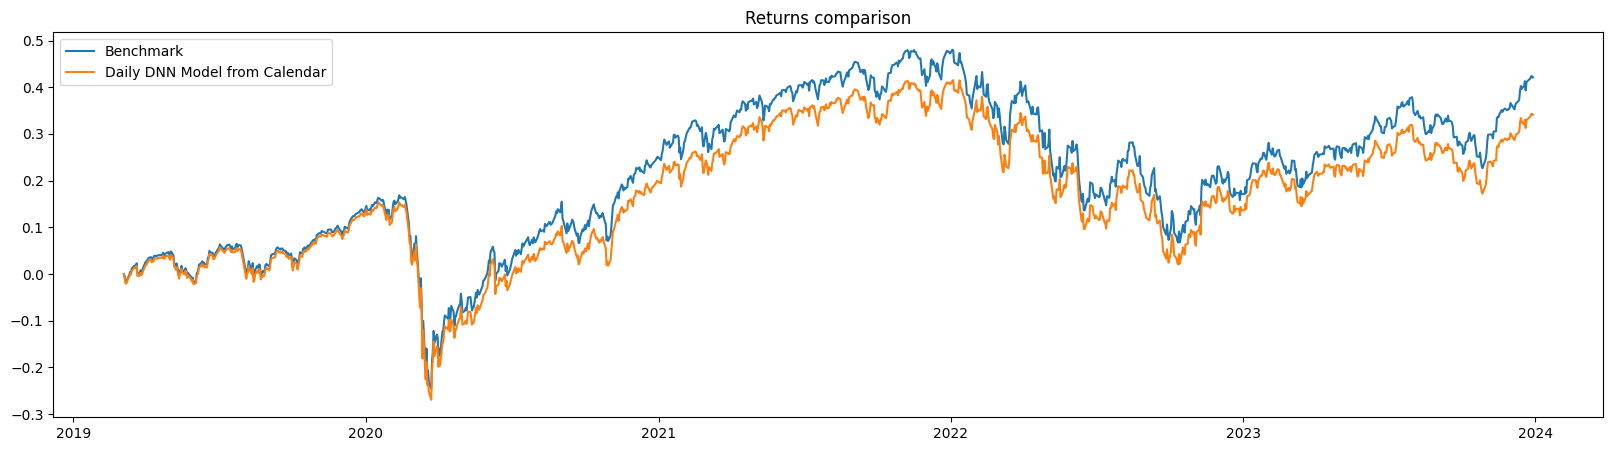

,Annual Returns,Annual Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,Max Time Under Water,Calmar Ratio,Information Ratio
Benchmark,0.0768,0.2033,0.3775,0.4420,-0.3548,500.0,0.2163,0.0000
Daily DNN Model from Calendar,0.0635,0.2025,0.3134,0.3643,-0.3666,499.0,0.1732,-0.5888


In [6]:
models = {
    'Daily DNN Model from Calendar': (loaded_dnn_model, x_test),
}

df_results = run_full_backtesting(data_provider, models)
df_results

Backtesting returns exactly the same results and trained model

## Test calculate weights for today

Testing code that will be used to deploy the investment algorithm to AWS Lambda function

In [8]:
read_date = datetime.today().date()
no_months = 6
limit_date = (read_date - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
print('Reading indicators from', limit_date, 'to', read_date)

data_provider = DataProvider()
# We need to initialize correlations to fill missing values
data_provider.initialize_current_correlations(limit_date, read_date)
x_today = data_provider.calculate_principal_component_from_calendar(
    read_date, no_months, limit_date)
x_today = x_today.values.reshape(1, 6, 27)

loaded_dnn_model = Sequential((
    Input(shape=(6, 27)),
    Flatten(),
    Dense(32, activation='relu',
          kernel_regularizer=L2(0.2)),
    Dense(27, activation='softmax')
))
loaded_dnn_model.load_weights('daily_dnn_model_from_calendar.weights.h5')

predicted_weights = loaded_dnn_model.predict(x_today, verbose=False)
predictions = pd.Series(predicted_weights[0], 
                        index=data_provider.selected_countries)
predictions['Russia'] = 0 # Russia is uninvertible after 02/2022
predictions = predictions/predictions.sum()
print('Portfolio weights')
print(predictions)

Reading indicators from 2023-06-08 to 2024-06-08
Portfolio weights
United States     0.504437
Japan             0.072207
United Kingdom    0.063058
Canada            0.036927
France            0.027391
Switzerland       0.027577
Germany           0.024937
Australia         0.028135
Netherlands       0.011330
Sweden            0.011075
Hong Kong         0.011881
Spain             0.009579
Italy             0.009940
Singapore         0.009588
Denmark           0.010653
Finland           0.010043
Belgium           0.012664
Norway            0.008017
China             0.024990
Taiwan            0.013475
India             0.010932
Korea             0.019232
Brazil            0.013582
Russia            0.000000
South Africa      0.011178
Mexico            0.008032
Malaysia          0.009141
dtype: float32
